# Multiple Traveling Salesman Problem: Genetic Algorithm Tutorial
## 1. Introduction to the MTSP
The Multiple Traveling Salesman Problem (MTSP) is an extension of the classic Traveling Salesman Problem (TSP), where instead of a single salesman, multiple salesmen travel to visit a set of cities. Each city (except depots) must be visited exactly once by exactly one salesman, and each salesman must return to their starting depot.
The objective is to minimize the total distance traveled by all salesmen. This problem has numerous real-world applications:

- Vehicle routing for delivery services
- Task scheduling in manufacturing
- Drone mission planning
- Healthcare service routing

Mathematical Formulation
Given:

- A set of cities including depot(s)
- A cost/distance matrix between cities
- A number of salesmen

Find:

- An assignment of cities to salesmen
- The optimal route for each salesman

Such that:

- Each non-depot city is visited exactly once
- Each salesman starts and ends at a depot
- The total cost across all routes is minimized

## 2. Genetic Algorithms for the MTSP
Genetic Algorithms (GAs) are particularly well-suited for the MTSP because:

1. They can handle complex combinatorial optimization problems efficiently
2. They can explore diverse solutions in parallel
3. They naturally accommodate multiple objectives and constraints
4. They do not require specialized mathematical programming tools

Our implementation uses a sophisticated GA approach with specialized operators designed for the MTSP

## 3. Solution Representation
The key to a successful GA implementation is the solution representation. In our code, a solution is represented as:
```py
# Example solution structure for 3 travelers, 9 cities (including depot)
solution = [
    [2, 5, 8],       # Route for traveler 1: depot → 2 → 5 → 8 → depot
    [3, 9, 7],       # Route for traveler 2: depot → 3 → 9 → 7 → depot
    [4, 6]           # Route for traveler 3: depot → 4 → 6 → depot
]
```
Each solution is a list of routes, where each route is a list of cities to be visited by a traveler. The depot (usually city 1) is implicit at the beginning and end of each route and not included in the representation.

4. Initializing the Population
The population initialization is a critical step in our genetic algorithm. The initialize_population() method creates a diverse set of starting solutions:

```py
initialize_population(self):
    """
    Create an initial population of random solutions.
    
    Each solution is represented as a list of routes, one for each traveler.
    Each route is a sequence of cities (excluding the depot, which is implicit at start and end).
    """
    population = []
    
    for _ in range(self.population_size):
        # Create a random solution
        solution = self._create_random_solution()
        population.append(solution)
        
    self.population = population
    return population
```
The `_create_random_solution()` method uses two strategies for distributing cities:

Even distribution: Divides cities equally among travelers
Random distribution: Assigns cities randomly, ensuring each traveler has at least one city if possible

Additionally, we apply a simple 2-opt local search to improve each initial route:
```py
def _random_2opt(self, route, iterations=5):
    """
    Apply a simple 2-opt local search to improve a single route.
    Only performs a few iterations to maintain diversity in the population.
    """
    # Implementation details...
```
This initialization approach balances exploitation (through local search) and exploration (through randomization).

## 5. Crossover Operators

The crossover operation is central to genetic algorithms as it combines good solutions to potentially create even better ones. Our implementation provides two specialized crossover methods for MTSP:

### 5.1 Route Exchange Crossover

This method exchanges entire routes between parents:

```python
def _route_exchange_crossover(self, parent1, parent2):
    """
    Route Exchange Crossover: exchanges complete routes between parents.
    
    This preserves good routes while creating new combinations.
    """
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    if self.num_travelers < 2:
        return child1, child2
        
    # Select random routes to exchange
    num_routes_to_exchange = random.randint(1, max(1, self.num_travelers // 2))
    routes_to_exchange = random.sample(range(self.num_travelers), num_routes_to_exchange)
    
    # Exchange the selected routes
    for route_idx in routes_to_exchange:
        child1[route_idx], child2[route_idx] = child2[route_idx], child1[route_idx]
        
    # Repair solutions if needed (check for duplicates and missing cities)
    child1 = self._repair_solution(child1)
    child2 = self._repair_solution(child2)
    
    return child1, child2
```

**How it works:**
1. Create copies of both parents
2. Randomly select routes to exchange
3. Swap the selected routes between parents
4. Repair solutions if the exchange created invalid solutions (with duplicate cities or missing cities)

This approach preserves good route structures while creating new combinations.

### 5.2 Route Merge Crossover

This method combines parts of corresponding routes from both parents:

```python
def _route_merge_crossover(self, parent1, parent2):
    """
    Route Merge Crossover: merges corresponding routes, then rebuilds a valid solution.
    
    This combines parts of routes from both parents, creating more genetic diversity.
    """
    # Create empty routes for children
    child1 = [[] for _ in range(self.num_travelers)]
    child2 = [[] for _ in range(self.num_travelers)]
    
    # For each traveler's route
    for i in range(self.num_travelers):
        # Choose crossover points for both parents' routes
        if parent1[i] and parent2[i]:
            # Get crossover points
            p1_cross = random.randint(0, len(parent1[i]))
            p2_cross = random.randint(0, len(parent2[i]))
            
            # Create merged routes (may contain duplicates)
            merged1 = parent1[i][:p1_cross] + parent2[i][p2_cross:]
            merged2 = parent2[i][:p2_cross] + parent1[i][p1_cross:]
            
            # Keep only the first occurrence of each city
            child1[i] = self._remove_duplicates(merged1)
            child2[i] = self._remove_duplicates(merged2)
    
    # Repair solutions to ensure all cities are covered
    child1 = self._repair_solution(child1)
    child2 = self._repair_solution(child2)
    
    return child1, child2
```

**How it works:**
1. Create empty route structures for children
2. For each route position, select random crossover points in both parents
3. Create merged routes by combining segments from both parents
4. Remove duplicate cities from the merged routes
5. Repair the solutions to ensure all cities are covered

This approach creates more genetic diversity by mixing route segments rather than swapping entire routes.


## 6. Solution Repair Mechanism

After crossover operations, we may have invalid solutions with duplicate or missing cities. The repair mechanism is crucial for maintaining solution validity:

```python
def _repair_solution(self, solution):
    """
    Repair a solution to ensure all cities are visited exactly once.
    
    1. Find missing cities (cities that should be visited but aren't in any route)
    2. Find duplicate cities (cities that appear in multiple routes)
    3. Remove duplicates and add missing cities
    """
    # Get all cities in the solution
    included_cities = []
    for route in solution:
        included_cities.extend(route)
        
    # Find duplicate cities and their positions
    city_counts = defaultdict(list)
    for traveler_idx, route in enumerate(solution):
        for pos, city in enumerate(route):
            city_counts[city].append((traveler_idx, pos))
            
    # Extract duplicate cities (appearing more than once) and missing cities
    duplicate_cities = {city: positions for city, positions in city_counts.items() 
                       if len(positions) > 1}
    missing_cities = [city for city in self.non_depots if city not in included_cities]
    
    # Process duplicates by keeping the first occurrence and marking others for removal
    to_remove = []
    for city, positions in duplicate_cities.items():
        # Keep the first occurrence, mark others for removal
        for traveler_idx, pos in positions[1:]:
            to_remove.append((traveler_idx, pos))
    
    # Sort removals in reverse order (to maintain valid indices when removing)
    to_remove.sort(reverse=True)
    
    # Remove duplicates
    for traveler_idx, pos in to_remove:
        solution[traveler_idx].pop(pos)
    
    # Distribute missing cities to routes
    random.shuffle(missing_cities)
    for city in missing_cities:
        # Choose a route, preferring those with fewer cities for balance
        route_sizes = [(i, len(route)) for i, route in enumerate(solution)]
        route_idx = min(route_sizes, key=lambda x: x[1])[0]
        
        # Insert at a random position
        insert_pos = random.randint(0, len(solution[route_idx]))
        solution[route_idx].insert(insert_pos, city)
    
    return solution
```

**How the repair mechanism works:**
1. Identify all cities currently in the solution
2. Track the position of each city in the solution
3. Identify duplicate cities (appearing more than once)
4. Identify missing cities (not appearing in any route)
5. Remove duplicate occurrences, keeping only the first one
6. Add missing cities to routes, prioritizing routes with fewer cities for balance

This repair mechanism is essential for maintaining the validity constraint that each city must be visited exactly once.


## 7. Mutation Operators

Mutation introduces small changes to solutions to maintain diversity and explore new areas of the solution space. Our implementation includes four types of mutation:

1. **Swap Mutation**: Swaps two random cities within a route
2. **Insert Mutation**: Moves a city to a different position within its route
3. **Inversion Mutation**: Reverses a segment of a route
4. **Redistribution Mutation**: Moves a city from one route to another

Here's how the redistribution mutation works:

```python
def _redistribution_mutation(self, solution):
    """Move a city from one route to another."""
    mutated = deepcopy(solution)
    
    if self.num_travelers < 2:
        return mutated
        
    # Find a non-empty route to take a city from
    non_empty_routes = [i for i, route in enumerate(mutated) if route]
    if not non_empty_routes:
        return mutated
        
    from_route_idx = random.choice(non_empty_routes)
    to_route_idx = random.randint(0, self.num_travelers - 1)
    while to_route_idx == from_route_idx:
        to_route_idx = random.randint(0, self.num_travelers - 1)
        
    # Move a random city from one route to another
    if mutated[from_route_idx]:
        city_pos = random.randint(0, len(mutated[from_route_idx]) - 1)
        city = mutated[from_route_idx].pop(city_pos)
        
        insert_pos = random.randint(0, len(mutated[to_route_idx]))
        mutated[to_route_idx].insert(insert_pos, city)
        
    return mutated
```

This mutation type is particularly important for MTSP as it helps explore different assignments of cities to travelers.


## 8. Selection and Elitism

The selection process determines which individuals will contribute to the next generation:

```python
def select_parents(self):
    """
    Select parents using tournament selection.
    
    Returns:
        Two parent solutions
    """
    def tournament():
        participants = random.sample(range(len(self.population)), self.tournament_size)
        participants_fitness = [(p, self.evaluate_fitness(self.population[p])) for p in participants]
        winner = min(participants_fitness, key=lambda x: x[1])[0]
        return self.population[winner]
    
    parent1 = tournament()
    parent2 = tournament()
    return parent1, parent2
```

We use tournament selection, which:
1. Randomly selects a subset of the population
2. Evaluates the fitness of each selected individual
3. Returns the fittest individual as the winner

Additionally, our evolution process includes elitism:

```python
# Keep elite solutions
num_elite = max(1, int(self.elitism_rate * self.population_size))
elite_indices = [idx for idx, _ in population_fitness[:num_elite]]
new_population = [deepcopy(self.population[idx]) for idx in elite_indices]
```

Elitism ensures that the best solutions are preserved across generations, preventing loss of good solutions.


## 9. Fitness Evaluation

The fitness function evaluates the quality of each solution:

```python
def evaluate_fitness(self, solution):
    """Calculate the fitness (total cost) of a solution."""
    total_cost = 0
    
    for route in solution:
        total_cost += self._route_cost(route)
        
    return total_cost

def _route_cost(self, route):
    """Calculate the cost of a single route including return to depot."""
    if not route:  # Empty route
        return 0
        
    # Default depot is the first one in the list
    depot = self.depots[0]
    
    # Start at depot, visit all cities in route, return to depot
    cost = self.cost_matrix[depot-1][route[0]-1]  # From depot to first city
    
    for i in range(len(route) - 1):
        cost += self.cost_matrix[route[i]-1][route[i+1]-1]
        
    cost += self.cost_matrix[route[-1]-1][depot-1]  # Return to depot
    return cost
```

The fitness is the total cost of all routes, where each route's cost includes:
1. Travel from the depot to the first city
2. Travel between all cities in the route
3. Return travel from the last city to the depot


## 10. Evolution Process

The evolution process brings together all the components:

```py
def evolve_population(self):
    """
    Evolve the population to the next generation using elitism, crossover, and mutation.
    """
    # Evaluate current population
    population_fitness = [(i, self.evaluate_fitness(solution)) 
                          for i, solution in enumerate(self.population)]
    
    # Sort by fitness (lower is better)
    population_fitness.sort(key=lambda x: x[1])
    
    # Keep elite solutions
    num_elite = max(1, int(self.elitism_rate * self.population_size))
    elite_indices = [idx for idx, _ in population_fitness[:num_elite]]
    new_population = [deepcopy(self.population[idx]) for idx in elite_indices]
    
    # Fill the rest of the population with offspring
    while len(new_population) < self.population_size:
        # Select parents
        parent1, parent2 = self.select_parents()
        
        # Crossover
        child1, child2 = self.crossover(parent1, parent2)
        
        # Mutation
        child1 = self.mutate(child1)
        child2 = self.mutate(child2)
        
        # Add to new population
        new_population.append(child1)
        if len(new_population) < self.population_size:
            new_population.append(child2)
    
    self.population = new_population
```

For each generation:
1. Evaluate the fitness of all solutions
2. Sort solutions by fitness
3. Preserve elite solutions
4. Generate offspring through selection, crossover, and mutation
5. Replace the current population with the new one


## 11. Complete Solver

The `solve()` method brings everything together:

```python
def solve(self, verbose=True, early_stopping_generations=50):
    """
    Run the genetic algorithm to solve the MTSP.
    """
    # Initialize population
    self.initialize_population()
    
    # Main loop
    for generation in range(self.generations):
        # Evolve population
        self.evolve_population()
        
        # Find best solution in current population
        # ...
        
        # Update global best
        # ...
        
        # Early stopping
        if generations_without_improvement >= early_stopping_generations:
            if verbose:
                print(f"Early stopping at generation {generation}...")
            break
    
    # Return results
    return best_solution, best_fitness
```


## 12. Tips for Improving Convergence

To improve the convergence of the genetic algorithm for MTSP:

### Parameter Tuning
- **Population size**: Larger populations (200-500) explore more of the solution space but require more computation
- **Mutation rate**: Typically 0.1-0.3, higher rates increase exploration but can disrupt good solutions
- **Crossover rate**: Usually 0.7-0.9, controls the balance between exploration and exploitation
- **Elitism rate**: Usually 0.05-0.2, preserves good solutions while allowing exploration

### Enhanced Initialization
- Use k-means clustering to assign cities to travelers before optimization
- Apply more iterations of 2-opt to initial solutions (10-20 iterations)
- Include some heuristically constructed solutions in the initial population

### Advanced Operators
- Implement path-based crossover operators like Order Crossover (OX) or Partially Mapped Crossover (PMX) for individual routes
- Add a local search step after mutation (memetic algorithm approach)
- Implement adaptive mutation rates that decrease as the algorithm converges

### Diversity Preservation
- Implement island models with migration between sub-populations
- Use fitness sharing to maintain diversity
- Add a diversity measure to selection criteria

## 13. Alternative Approaches

While genetic algorithms are effective for MTSP, consider these alternatives:

### 1. Simulated Annealing
- Uses a temperature parameter to control exploration vs. exploitation
- Pros: Simple implementation, good for local search
- Cons: Parameter tuning can be difficult

### 2. Ant Colony Optimization
- Models the problem using artificial ants that deposit pheromones
- Pros: Works well for routing problems
- Cons: Slower convergence than GAs for some instances

### 3. Tabu Search
- Uses memory structures to avoid revisiting previous solutions
- Pros: Escapes local optima effectively
- Cons: Memory requirements can be high

### 4. Hybrid Approaches
- Combine GA with local search (memetic algorithms)
- Use clustering for initial assignment, then optimize routes
- Decompose the problem into assignment and routing sub-problems

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time
import csv
from collections import defaultdict
from copy import deepcopy

class GeneticAlgorithmMTSP:
    """
    Genetic Algorithm for Multiple Traveling Salesman Problem (MTSP) with multiple depots.
    
    This implementation uses advanced crossover and mutation operators specifically designed 
    for MTSP as recommended in academic literature.
    """
    
    def __init__(self, cost_matrix, num_cities, num_travelers=3, depots=None, 
                 population_size=100, generations=500, mutation_rate=0.2, 
                 crossover_rate=0.8, elitism_rate=0.1, tournament_size=5):
        """
        Initialize the Genetic Algorithm solver.
        
        Args:
            cost_matrix (np.array): Square matrix of costs between cities
            num_cities (int): Total number of cities including depots
            num_travelers (int): Number of travelers/salesmen
            depots (list): List of depot indices (1-indexed), defaults to [1]
            population_size (int): Size of the population
            generations (int): Maximum number of generations
            mutation_rate (float): Probability of mutation
            crossover_rate (float): Probability of crossover
            elitism_rate (float): Proportion of elite solutions to keep
            tournament_size (int): Size of tournament for selection
        """
        self.cost_matrix = cost_matrix
        self.num_cities = num_cities
        self.num_travelers = num_travelers
        
        # Default to node 1 if no depots are specified (1-indexed)
        if depots is None:
            self.depots = [1]
        else:
            self.depots = depots
            
        # Create a set of non-depot cities (1-indexed)
        self.non_depots = [i for i in range(1, num_cities + 1) if i not in self.depots]
        
        # GA parameters
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_rate = elitism_rate
        self.tournament_size = tournament_size
        
        # Results storage
        self.best_solution = None
        self.best_fitness = float('inf')
        self.fitness_history = []
        self.best_solution_history = []
        self.population = []
        
    def initialize_population(self):
        """
        Create an initial population of random solutions.
        
        Each solution is represented as a list of routes, one for each traveler.
        Each route is a sequence of cities (excluding the depot, which is implicit at start and end).
        """
        population = []
        
        for _ in range(self.population_size):
            # Create a random solution
            solution = self._create_random_solution()
            population.append(solution)
            
        self.population = population
        return population
    
    def _create_random_solution(self):
        """
        Create a random valid solution.
        
        Returns:
            List of routes, one per traveler. Each route is a list of cities.
        """
        # Make a copy of non-depot cities that need to be visited
        cities_to_visit = self.non_depots.copy()
        random.shuffle(cities_to_visit)
        
        # Partition the cities among travelers
        routes = [[] for _ in range(self.num_travelers)]
        
        # Two strategies: either distribute evenly or randomly
        if random.random() < 0.5:  # Distribute evenly
            cities_per_traveler = len(cities_to_visit) // self.num_travelers
            remainder = len(cities_to_visit) % self.num_travelers
            
            start_idx = 0
            for i in range(self.num_travelers):
                # Add one extra city to some travelers if there's a remainder
                extra = 1 if i < remainder else 0
                end_idx = start_idx + cities_per_traveler + extra
                routes[i] = cities_to_visit[start_idx:end_idx]
                start_idx = end_idx
        else:  # Distribute randomly but ensure each traveler has at least one city if possible
            min_cities = min(1, len(cities_to_visit) // self.num_travelers)
            
            # First, ensure minimum cities per traveler
            for i in range(self.num_travelers):
                if len(cities_to_visit) >= min_cities:
                    routes[i] = cities_to_visit[:min_cities]
                    cities_to_visit = cities_to_visit[min_cities:]
            
            # Then distribute remaining cities randomly
            while cities_to_visit:
                traveler_idx = random.randint(0, self.num_travelers - 1)
                routes[traveler_idx].append(cities_to_visit.pop(0))
        
        # Optimize each traveler's route with a random 2-opt improvement
        for i in range(self.num_travelers):
            if len(routes[i]) > 3:  # Only worth optimizing if route has enough cities
                routes[i] = self._random_2opt(routes[i])
                
        return routes
    
    def _random_2opt(self, route, iterations=5):
        """
        Apply a simple 2-opt local search to improve a single route.
        Only performs a few iterations to maintain diversity in the population.
        """
        best_route = route.copy()
        best_cost = self._route_cost(best_route)
        
        for _ in range(iterations):
            if len(route) < 4:
                break
                
            # Select random segment to reverse
            i, j = sorted(random.sample(range(len(route)), 2))
            
            # Apply 2-opt: reverse the segment between i and j
            new_route = best_route[:i] + best_route[i:j+1][::-1] + best_route[j+1:]
            new_cost = self._route_cost(new_route)
            
            if new_cost < best_cost:
                best_route = new_route
                best_cost = new_cost
                
        return best_route
    
    def _route_cost(self, route):
        """Calculate the cost of a single route including return to depot."""
        if not route:  # Empty route
            return 0
            
        # Default depot is the first one in the list
        depot = self.depots[0]
        
        # Start at depot, visit all cities in route, return to depot
        cost = self.cost_matrix[depot-1][route[0]-1]  # From depot to first city
        
        for i in range(len(route) - 1):
            cost += self.cost_matrix[route[i]-1][route[i+1]-1]
            
        cost += self.cost_matrix[route[-1]-1][depot-1]  # Return to depot
        return cost
    
    def evaluate_fitness(self, solution):
        """Calculate the fitness (total cost) of a solution."""
        total_cost = 0
        
        for route in solution:
            total_cost += self._route_cost(route)
            
        return total_cost
    
    def select_parents(self):
        """
        Select parents using tournament selection.
        
        Returns:
            Two parent solutions
        """
        def tournament():
            participants = random.sample(range(len(self.population)), self.tournament_size)
            participants_fitness = [(p, self.evaluate_fitness(self.population[p])) for p in participants]
            winner = min(participants_fitness, key=lambda x: x[1])[0]
            return self.population[winner]
        
        parent1 = tournament()
        parent2 = tournament()
        return parent1, parent2
    
    def crossover(self, parent1, parent2):
        """
        Perform crossover between two parents.
        
        This uses a specialized route-based crossover operator for MTSP:
        1. Route Exchange Crossover - exchanges whole routes between parents
        2. Route Merge Crossover - merges routes between parents and redistributes cities
        
        Returns:
            Two child solutions
        """
        if random.random() > self.crossover_rate:
            return deepcopy(parent1), deepcopy(parent2)
        
        # Choose crossover type: route exchange or route merge
        if random.random() < 0.5:
            return self._route_exchange_crossover(parent1, parent2)
        else:
            return self._route_merge_crossover(parent1, parent2)
    
    def _route_exchange_crossover(self, parent1, parent2):
        """
        Route Exchange Crossover: exchanges complete routes between parents.
        
        This preserves good routes while creating new combinations.
        """
        child1 = deepcopy(parent1)
        child2 = deepcopy(parent2)
        
        if self.num_travelers < 2:
            return child1, child2
            
        # Select random routes to exchange
        num_routes_to_exchange = random.randint(1, max(1, self.num_travelers // 2))
        routes_to_exchange = random.sample(range(self.num_travelers), num_routes_to_exchange)
        
        # Exchange the selected routes
        for route_idx in routes_to_exchange:
            child1[route_idx], child2[route_idx] = child2[route_idx], child1[route_idx]
            
        # Repair solutions if needed (check for duplicates and missing cities)
        child1 = self._repair_solution(child1)
        child2 = self._repair_solution(child2)
        
        return child1, child2
    
    def _route_merge_crossover(self, parent1, parent2):
        """
        Route Merge Crossover: merges corresponding routes, then rebuilds a valid solution.
        
        This combines parts of routes from both parents, creating more genetic diversity.
        """
        # Collect all cities from both parents (excluding depots)
        all_cities = set(self.non_depots)
        
        # Create empty routes for children
        child1 = [[] for _ in range(self.num_travelers)]
        child2 = [[] for _ in range(self.num_travelers)]
        
        # For each traveler's route
        for i in range(self.num_travelers):
            # Choose crossover points for both parents' routes
            if parent1[i] and parent2[i]:
                # Get crossover points
                p1_cross = random.randint(0, len(parent1[i]))
                p2_cross = random.randint(0, len(parent2[i]))
                
                # Create merged routes (may contain duplicates)
                merged1 = parent1[i][:p1_cross] + parent2[i][p2_cross:]
                merged2 = parent2[i][:p2_cross] + parent1[i][p1_cross:]
                
                # Keep only the first occurrence of each city
                child1[i] = self._remove_duplicates(merged1)
                child2[i] = self._remove_duplicates(merged2)
        
        # Repair solutions to ensure all cities are covered
        child1 = self._repair_solution(child1)
        child2 = self._repair_solution(child2)
        
        return child1, child2
    
    def _remove_duplicates(self, route):
        """Remove duplicate cities from a route, keeping the first occurrence."""
        seen = set()
        result = []
        for city in route:
            if city not in seen:
                seen.add(city)
                result.append(city)
        return result
    
    def _repair_solution(self, solution):
        """
        Repair a solution to ensure all cities are visited exactly once.
        
        1. Find missing cities (cities that should be visited but aren't in any route)
        2. Find duplicate cities (cities that appear in multiple routes)
        3. Remove duplicates and add missing cities
        """
        # Get all cities in the solution
        included_cities = []
        for route in solution:
            included_cities.extend(route)
            
        # Find duplicate cities and their positions
        city_counts = defaultdict(list)
        for traveler_idx, route in enumerate(solution):
            for pos, city in enumerate(route):
                city_counts[city].append((traveler_idx, pos))
                
        # Extract duplicate cities (appearing more than once) and missing cities
        duplicate_cities = {city: positions for city, positions in city_counts.items() 
                           if len(positions) > 1}
        missing_cities = [city for city in self.non_depots if city not in included_cities]
        
        # Process duplicates by keeping the first occurrence and marking others for removal
        to_remove = []
        for city, positions in duplicate_cities.items():
            # Keep the first occurrence, mark others for removal
            for traveler_idx, pos in positions[1:]:
                to_remove.append((traveler_idx, pos))
        
        # Sort removals in reverse order (to maintain valid indices when removing)
        to_remove.sort(reverse=True)
        
        # Remove duplicates
        for traveler_idx, pos in to_remove:
            solution[traveler_idx].pop(pos)
        
        # Distribute missing cities to routes
        random.shuffle(missing_cities)
        for city in missing_cities:
            # Choose a route, preferring those with fewer cities for balance
            route_sizes = [(i, len(route)) for i, route in enumerate(solution)]
            route_idx = min(route_sizes, key=lambda x: x[1])[0]
            
            # Insert at a random position
            insert_pos = random.randint(0, len(solution[route_idx]))
            solution[route_idx].insert(insert_pos, city)
        
        return solution
    
    def mutate(self, solution):
        """
        Apply mutation operators to the solution.
        
        Uses several mutation types:
        1. Swap mutation - swaps cities within a route
        2. Insert mutation - moves a city to a different position
        3. Inversion mutation - reverses a segment of a route
        4. Redistribution mutation - moves cities between routes
        
        Returns:
            Mutated solution
        """
        if random.random() > self.mutation_rate:
            return solution
            
        # Choose mutation type
        mutation_type = random.choice(['swap', 'insert', 'invert', 'redistribute'])
        
        if mutation_type == 'swap':
            return self._swap_mutation(solution)
        elif mutation_type == 'insert':
            return self._insert_mutation(solution)
        elif mutation_type == 'invert':
            return self._inversion_mutation(solution)
        else:  # redistribute
            return self._redistribution_mutation(solution)
    
    def _swap_mutation(self, solution):
        """Swap two random cities within a random route."""
        mutated = deepcopy(solution)
        
        # Select a non-empty route
        non_empty_routes = [i for i, route in enumerate(mutated) if len(route) >= 2]
        if not non_empty_routes:
            return mutated
            
        route_idx = random.choice(non_empty_routes)
        route = mutated[route_idx]
        
        # Swap two random positions
        pos1, pos2 = random.sample(range(len(route)), 2)
        route[pos1], route[pos2] = route[pos2], route[pos1]
        
        return mutated
    
    def _insert_mutation(self, solution):
        """Move a random city to a different position in its route."""
        mutated = deepcopy(solution)
        
        # Select a non-empty route
        non_empty_routes = [i for i, route in enumerate(mutated) if len(route) >= 2]
        if not non_empty_routes:
            return mutated
            
        route_idx = random.choice(non_empty_routes)
        route = mutated[route_idx]
        
        # Select a city and a new position
        old_pos = random.randint(0, len(route) - 1)
        new_pos = random.randint(0, len(route) - 1)
        while new_pos == old_pos:
            new_pos = random.randint(0, len(route) - 1)
            
        # Remove city from old position and insert at new position
        city = route.pop(old_pos)
        route.insert(new_pos, city)
        
        return mutated
    
    def _inversion_mutation(self, solution):
        """Reverse a segment of a random route."""
        mutated = deepcopy(solution)
        
        # Select a route with enough cities
        eligible_routes = [i for i, route in enumerate(mutated) if len(route) >= 3]
        if not eligible_routes:
            return mutated
            
        route_idx = random.choice(eligible_routes)
        route = mutated[route_idx]
        
        # Select two positions and reverse the segment between them
        pos1, pos2 = sorted(random.sample(range(len(route)), 2))
        mutated[route_idx] = route[:pos1] + route[pos1:pos2+1][::-1] + route[pos2+1:]
        
        return mutated
    
    def _redistribution_mutation(self, solution):
        """Move a city from one route to another."""
        mutated = deepcopy(solution)
        
        if self.num_travelers < 2:
            return mutated
            
        # Find a non-empty route to take a city from
        non_empty_routes = [i for i, route in enumerate(mutated) if route]
        if not non_empty_routes:
            return mutated
            
        from_route_idx = random.choice(non_empty_routes)
        to_route_idx = random.randint(0, self.num_travelers - 1)
        while to_route_idx == from_route_idx:
            to_route_idx = random.randint(0, self.num_travelers - 1)
            
        # Move a random city from one route to another
        if mutated[from_route_idx]:
            city_pos = random.randint(0, len(mutated[from_route_idx]) - 1)
            city = mutated[from_route_idx].pop(city_pos)
            
            insert_pos = random.randint(0, len(mutated[to_route_idx]))
            mutated[to_route_idx].insert(insert_pos, city)
            
        return mutated
    
    def evolve_population(self):
        """
        Evolve the population to the next generation using elitism, crossover, and mutation.
        """
        # Evaluate current population
        population_fitness = [(i, self.evaluate_fitness(solution)) 
                              for i, solution in enumerate(self.population)]
        
        # Sort by fitness (lower is better)
        population_fitness.sort(key=lambda x: x[1])
        
        # Keep elite solutions
        num_elite = max(1, int(self.elitism_rate * self.population_size))
        elite_indices = [idx for idx, _ in population_fitness[:num_elite]]
        new_population = [deepcopy(self.population[idx]) for idx in elite_indices]
        
        # Fill the rest of the population with offspring
        while len(new_population) < self.population_size:
            # Select parents
            parent1, parent2 = self.select_parents()
            
            # Crossover
            child1, child2 = self.crossover(parent1, parent2)
            
            # Mutation
            child1 = self.mutate(child1)
            child2 = self.mutate(child2)
            
            # Add to new population
            new_population.append(child1)
            if len(new_population) < self.population_size:
                new_population.append(child2)
        
        self.population = new_population
    
    def solve(self, verbose=True, early_stopping_generations=50):
        """
        Run the genetic algorithm to solve the MTSP.
        
        Args:
            verbose (bool): Whether to print progress information
            early_stopping_generations (int): Stop if no improvement for this many generations
            
        Returns:
            best_solution, best_fitness
        """
        # Initialize population
        self.initialize_population()
        
        # Track best solution and convergence
        best_solution = None
        best_fitness = float('inf')
        generations_without_improvement = 0
        start_time = time.time()
        
        # Main loop
        for generation in range(self.generations):
            # Evolve population
            self.evolve_population()
            
            # Find best solution in current population
            current_best = None
            current_best_fitness = float('inf')
            
            for solution in self.population:
                fitness = self.evaluate_fitness(solution)
                if fitness < current_best_fitness:
                    current_best = solution
                    current_best_fitness = fitness
            
            # Update global best
            if current_best_fitness < best_fitness:
                best_solution = deepcopy(current_best)
                best_fitness = current_best_fitness
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1
            
            # Store history
            self.fitness_history.append(current_best_fitness)
            self.best_solution_history.append(best_fitness)
            
            # Print progress
            if verbose and generation % 10 == 0:
                elapsed_time = time.time() - start_time
                print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}, "
                      f"Current Best = {current_best_fitness:.2f}, "
                      f"Time = {elapsed_time:.2f}s")
            
            # Early stopping
            if generations_without_improvement >= early_stopping_generations:
                if verbose:
                    print(f"Early stopping at generation {generation} due to no improvement "
                          f"for {early_stopping_generations} generations.")
                break
        
        # Final results
        self.best_solution = best_solution
        self.best_fitness = best_fitness
        
        if verbose:
            total_time = time.time() - start_time
            print(f"Optimization complete. Best fitness: {best_fitness:.2f}, "
                  f"Time: {total_time:.2f}s")
            
        return best_solution, best_fitness
    
    def plot_convergence(self):
        """Plot the convergence of the genetic algorithm."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.fitness_history, label='Current Generation Best')
        plt.plot(self.best_solution_history, label='All-Time Best')
        plt.xlabel('Generation')
        plt.ylabel('Fitness (Total Cost)')
        plt.title('Genetic Algorithm Convergence')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_solution(self):
        """Visualize the best solution found."""
        if not self.best_solution:
            print("No solution to visualize yet. Run solve() first.")
            return
        
        # Create a directed graph
        G = nx.DiGraph()
        
        # Add all nodes
        for i in range(1, self.num_cities + 1):
            if i in self.depots:
                G.add_node(i, color='red')  # Depots in red
            else:
                G.add_node(i, color='lightblue')  # Regular cities in blue
        
        # Add edges for each traveler's route
        edge_colors = plt.cm.Set1.colors
        num_colors = len(edge_colors)
        
        for traveler_idx, route in enumerate(self.best_solution):
            if not route:
                continue
                
            # Default depot is the first one in the list
            depot = self.depots[0]
            
            # Add edge from depot to first city
            G.add_edge(depot, route[0], color=edge_colors[traveler_idx % num_colors], 
                       traveler=traveler_idx+1)
            
            # Add edges between cities
            for i in range(len(route) - 1):
                G.add_edge(route[i], route[i+1], color=edge_colors[traveler_idx % num_colors], 
                           traveler=traveler_idx+1)
            
            # Add edge from last city back to depot
            G.add_edge(route[-1], depot, color=edge_colors[traveler_idx % num_colors], 
                       traveler=traveler_idx+1)
        
        # Position nodes using spring layout
        pos = nx.spring_layout(G, seed=42)
        
        # Draw the graph
        plt.figure(figsize=(12, 8))
        
        # Draw nodes
        node_colors = ['red' if i in self.depots else 'lightblue' for i in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
        
        # Draw edges with color by traveler
        for (u, v, data) in G.edges(data=True):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], 
                                   edge_color=[data['color']], 
                                   width=2, 
                                   arrows=True)
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_weight='bold')
        
        # Add legend
        legend_elements = [plt.Line2D([0], [0], color=edge_colors[i % num_colors], lw=2, 
                                      label=f'Traveler {i+1}') 
                          for i in range(self.num_travelers)]
        plt.legend(handles=legend_elements)
        
        plt.title('Multiple Traveling Salesmen Solution')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def get_solution_details(self):
        """Return detailed information about the best solution."""
        if not self.best_solution:
            return "No solution found yet."
            
        details = []
        total_cost = 0
        depot = self.depots[0]  # Default to first depot
        
        details.append("Solution Details:")
        details.append(f"Total Fitness (Cost): {self.best_fitness:.2f}")
        details.append(f"Depot: {depot}")
        details.append("")
        
        for i, route in enumerate(self.best_solution):
            if not route:
                cost = 0
                details.append(f"Traveler {i+1}: No cities to visit. Cost: {cost:.2f}")
                continue
                
            route_with_depot = [depot] + route + [depot]
            route_str = " -> ".join(str(city) for city in route_with_depot)
            
            cost = 0
            for j in range(len(route_with_depot) - 1):
                from_city = route_with_depot[j]
                to_city = route_with_depot[j + 1]
                segment_cost = self.cost_matrix[from_city-1][to_city-1]
                cost += segment_cost
                
            total_cost += cost
            details.append(f"Traveler {i+1}: {route_str}. Cost: {cost:.2f}")
            
        details.append("")
        details.append(f"Total Cost: {total_cost:.2f}")
        
        return "\n".join(details)


def read_cost_matrix_csv(filename):
    """
    Reads a cost matrix from a CSV file.
    
    Supports two formats:
    1. Standard format: First row contains node IDs, subsequent rows contain the matrix
    2. Arrow format: Each row starts with "node_id→" followed by comma-separated costs
    
    Parameters:
        filename (str): The name of the CSV file.
    
    Returns:
        cost_matrix (np.array): A 2D numpy array representing the cost matrix.
    """
    with open(filename, 'r', newline='') as file:
        first_line = file.readline().strip()
        file.seek(0)  # Reset to beginning
        
        # Check if it's the arrow format (contains →)
        if '→' in first_line:
            # Arrow format: each line is "node_id→cost1,cost2,..."
            data = []
            for line in file:
                line = line.strip()
                if not line:  # Skip empty lines
                    continue
                # Split by → to separate node_id from costs
                parts = line.split('→')
                if len(parts) == 2:
                    # Get the costs part and split by comma
                    costs = parts[1].split(',')
                    data.append([float(c) for c in costs])
            
            cost_matrix = np.array(data, dtype=float)
        else:
            # Standard format: first row is header, rest is data
            reader = csv.reader(file)
            next(reader)  # Skip header row
            data = list(reader)
            cost_matrix = np.array(data, dtype=float)
    
    return cost_matrix

## 14. Running Different Test Instances

Below are several examples running the genetic algorithm on different problem instances from the `cost_matrix/` directory. Each instance has different characteristics:

- **Small instances (n=5, n=10)**: Quick to solve, good for testing and understanding the algorithm
- **Medium instances (n=15, n=20)**: More challenging, require better parameter tuning
- **Large instances (n=50, n=100)**: Computationally intensive, benefit from larger populations and more generations
- **Different types**: Symmetric, asymmetric, grid-based, and non-metric instances

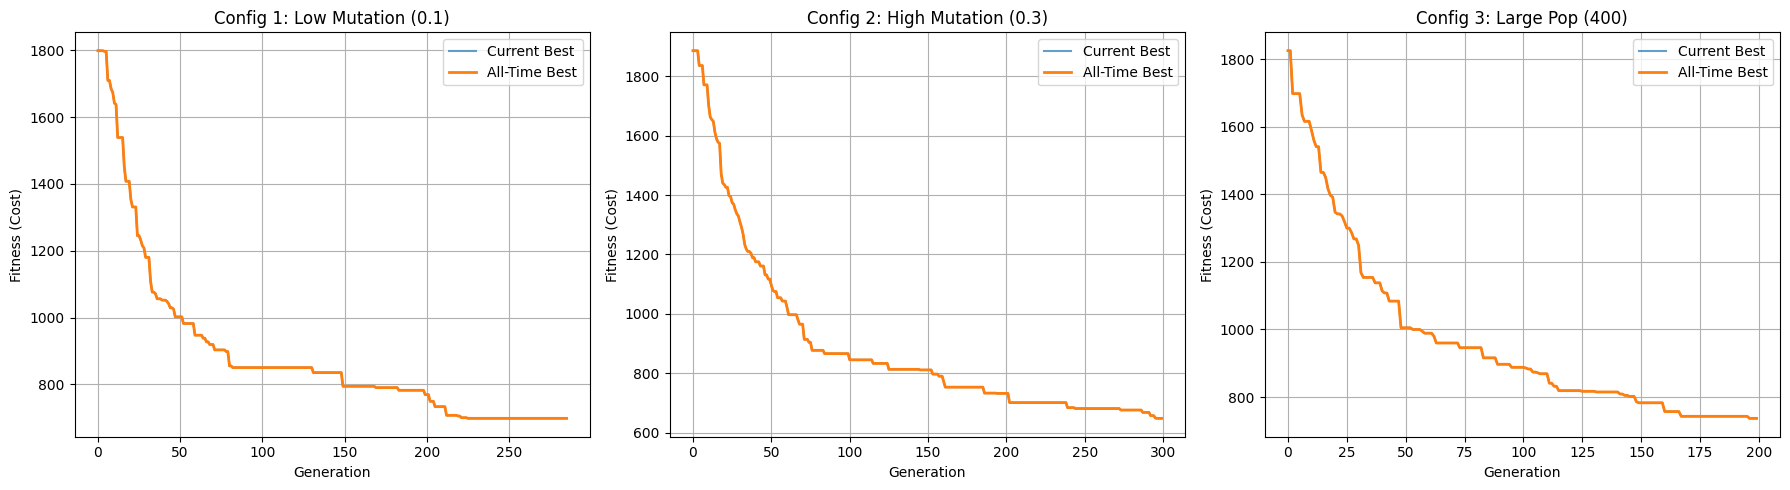

In [8]:
# Plot convergence comparison for the three configurations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Config 1
axes[0].plot(ga_5a.fitness_history, label='Current Best', alpha=0.7)
axes[0].plot(ga_5a.best_solution_history, label='All-Time Best', linewidth=2)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Fitness (Cost)')
axes[0].set_title('Config 1: Low Mutation (0.1)')
axes[0].legend()
axes[0].grid(True)

# Plot Config 2
axes[1].plot(ga_5b.fitness_history, label='Current Best', alpha=0.7)
axes[1].plot(ga_5b.best_solution_history, label='All-Time Best', linewidth=2)
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Fitness (Cost)')
axes[1].set_title('Config 2: High Mutation (0.3)')
axes[1].legend()
axes[1].grid(True)

# Plot Config 3
axes[2].plot(ga_5c.fitness_history, label='Current Best', alpha=0.7)
axes[2].plot(ga_5c.best_solution_history, label='All-Time Best', linewidth=2)
axes[2].set_xlabel('Generation')
axes[2].set_ylabel('Fitness (Cost)')
axes[2].set_title('Config 3: Large Pop (400)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Instance 1: Small Grid (5 nodes, 2 travelers)

In [9]:
# Instance 1: Small grid with 5 nodes
print("=" * 80)
print("INSTANCE 1: Grid Complete n=5")
print("=" * 80)

# Load cost matrix
cost_matrix_1 = read_cost_matrix_csv('cost_matrix/grid_complete_n5.csv')
num_cities_1 = len(cost_matrix_1)
num_travelers_1 = 2

print(f"Number of cities: {num_cities_1}")
print(f"Number of travelers: {num_travelers_1}")
print(f"Cost matrix shape: {cost_matrix_1.shape}\n")

# Create and run GA with smaller parameters for quick solve
ga_1 = GeneticAlgorithmMTSP(
    cost_matrix=cost_matrix_1,
    num_cities=num_cities_1,
    num_travelers=num_travelers_1,
    depots=[1],
    population_size=50,
    generations=100,
    mutation_rate=0.2,
    crossover_rate=0.8,
    elitism_rate=0.1,
    tournament_size=3
)

# Solve
best_solution_1, best_fitness_1 = ga_1.solve(verbose=True, early_stopping_generations=30)

# Display results
print("\n" + ga_1.get_solution_details())
print("\n" + "=" * 80 + "\n")

INSTANCE 1: Grid Complete n=5
Number of cities: 4
Number of travelers: 2
Cost matrix shape: (4, 5)

Generation 0: Best Fitness = 3.00, Current Best = 3.00, Time = 0.00s
Generation 10: Best Fitness = 1.00, Current Best = 1.00, Time = 0.01s
Generation 20: Best Fitness = 1.00, Current Best = 1.00, Time = 0.01s
Generation 30: Best Fitness = 1.00, Current Best = 1.00, Time = 0.02s
Early stopping at generation 31 due to no improvement for 30 generations.
Optimization complete. Best fitness: 1.00, Time: 0.02s

Solution Details:
Total Fitness (Cost): 1.00
Depot: 1

Traveler 1: 1 -> 2 -> 3 -> 4 -> 1. Cost: 1.00
Traveler 2: No cities to visit. Cost: 0.00

Total Cost: 1.00




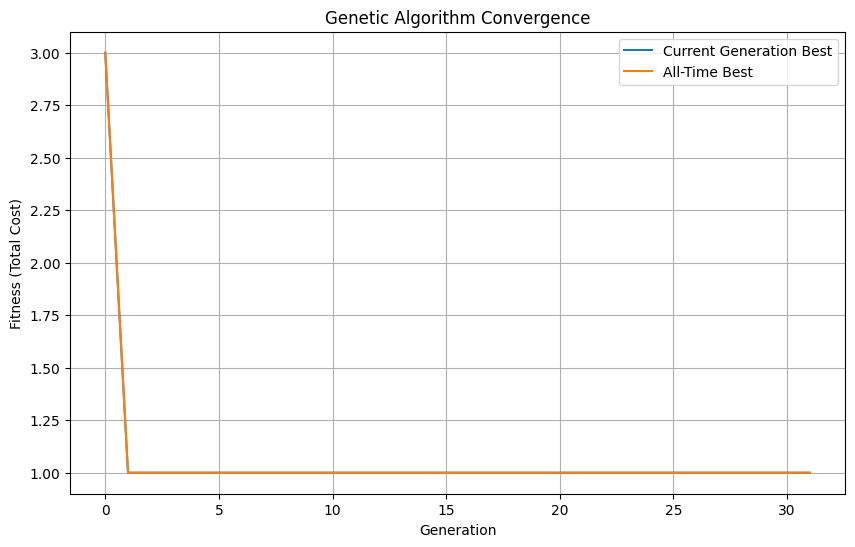

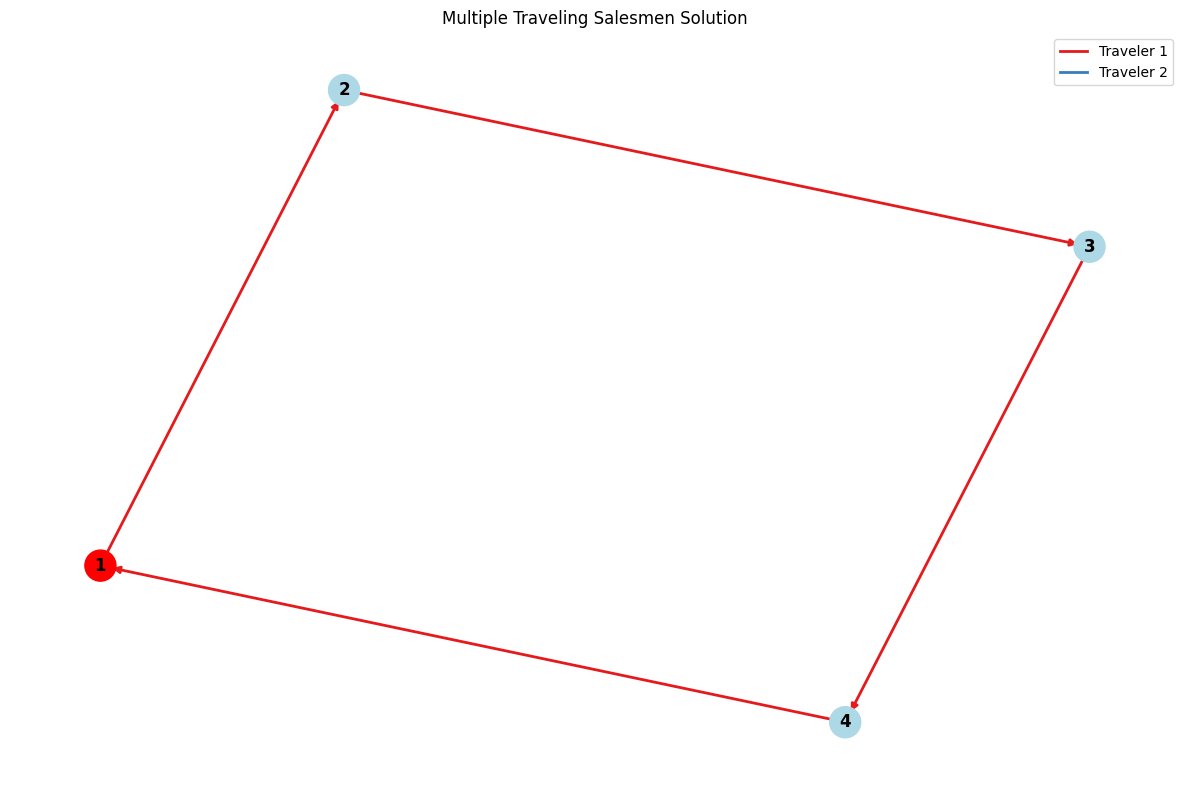

In [10]:
# Visualize Instance 1 results
ga_1.plot_convergence()
ga_1.plot_solution()

### Instance 2: Asymmetric from Symmetric (10 nodes, 3 travelers)

In [11]:
# Instance 2: Asymmetric matrix with 10 nodes
print("=" * 80)
print("INSTANCE 2: Asymmetric from Symmetric n=10")
print("=" * 80)

# Load cost matrix
cost_matrix_2 = read_cost_matrix_csv('cost_matrix/asymmetric_from_symmetric_n10.csv')
num_cities_2 = len(cost_matrix_2)
num_travelers_2 = 3

print(f"Number of cities: {num_cities_2}")
print(f"Number of travelers: {num_travelers_2}")
print(f"Cost matrix shape: {cost_matrix_2.shape}\n")

# Create and run GA
ga_2 = GeneticAlgorithmMTSP(
    cost_matrix=cost_matrix_2,
    num_cities=num_cities_2,
    num_travelers=num_travelers_2,
    depots=[1],
    population_size=100,
    generations=200,
    mutation_rate=0.2,
    crossover_rate=0.8,
    elitism_rate=0.1,
    tournament_size=5
)

# Solve
best_solution_2, best_fitness_2 = ga_2.solve(verbose=True, early_stopping_generations=40)

# Display results
print("\n" + ga_2.get_solution_details())
print("\n" + "=" * 80 + "\n")

INSTANCE 2: Asymmetric from Symmetric n=10
Number of cities: 9
Number of travelers: 3
Cost matrix shape: (9, 10)

Generation 0: Best Fitness = 335.00, Current Best = 335.00, Time = 0.00s
Generation 10: Best Fitness = 82.00, Current Best = 82.00, Time = 0.03s
Generation 20: Best Fitness = 82.00, Current Best = 82.00, Time = 0.05s
Generation 30: Best Fitness = 82.00, Current Best = 82.00, Time = 0.07s
Generation 40: Best Fitness = 82.00, Current Best = 82.00, Time = 0.09s
Early stopping at generation 49 due to no improvement for 40 generations.
Optimization complete. Best fitness: 82.00, Time: 0.11s

Solution Details:
Total Fitness (Cost): 82.00
Depot: 1

Traveler 1: 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 1. Cost: 82.00
Traveler 2: No cities to visit. Cost: 0.00
Traveler 3: No cities to visit. Cost: 0.00

Total Cost: 82.00




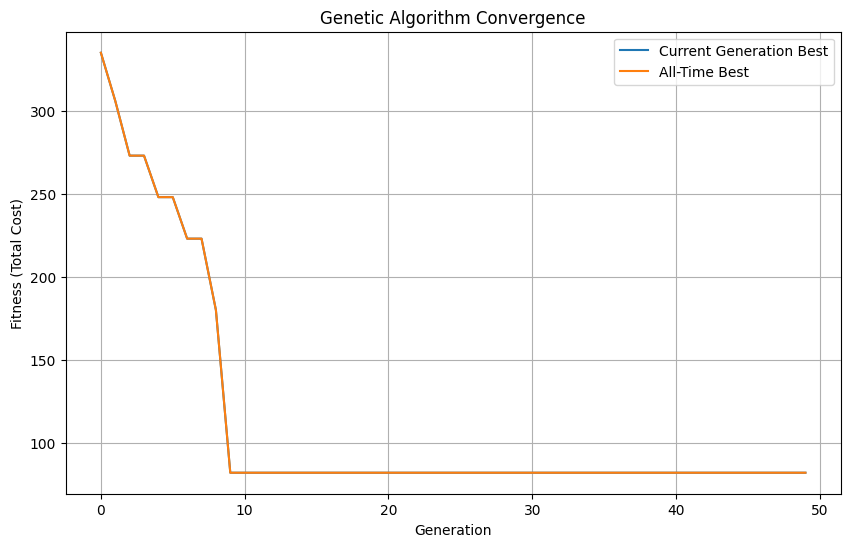

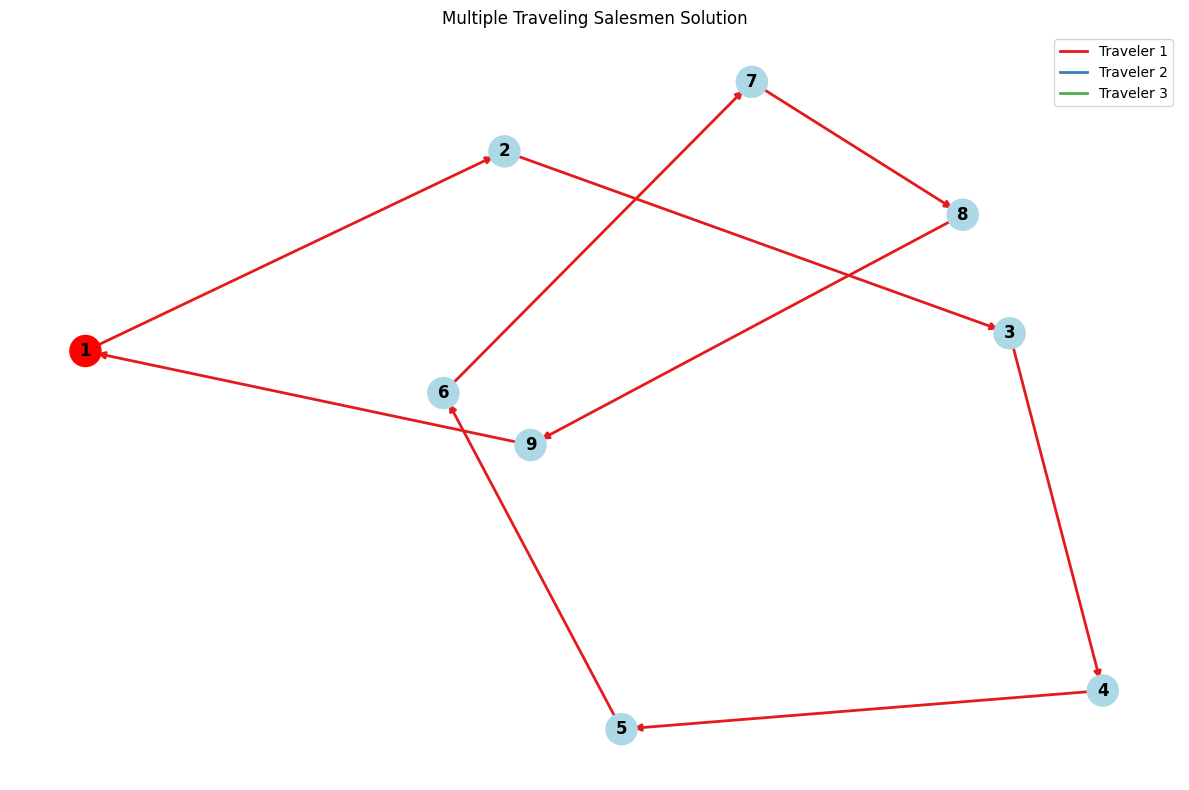

In [12]:
# Visualize Instance 2 results
ga_2.plot_convergence()
ga_2.plot_solution()

### Instance 3: Medium-sized Asymmetric (20 nodes, 4 travelers)

In [13]:
# Instance 3: Asymmetric matrix with 20 nodes
print("=" * 80)
print("INSTANCE 3: Asymmetric from Symmetric n=20")
print("=" * 80)

# Load cost matrix
cost_matrix_3 = read_cost_matrix_csv('cost_matrix/asymmetric_from_symmetric_n20.csv')
num_cities_3 = len(cost_matrix_3)
num_travelers_3 = 4

print(f"Number of cities: {num_cities_3}")
print(f"Number of travelers: {num_travelers_3}")
print(f"Cost matrix shape: {cost_matrix_3.shape}\n")

# Create and run GA with increased parameters for medium instance
ga_3 = GeneticAlgorithmMTSP(
    cost_matrix=cost_matrix_3,
    num_cities=num_cities_3,
    num_travelers=num_travelers_3,
    depots=[1],
    population_size=150,
    generations=300,
    mutation_rate=0.25,
    crossover_rate=0.85,
    elitism_rate=0.1,
    tournament_size=5
)

# Solve
best_solution_3, best_fitness_3 = ga_3.solve(verbose=True, early_stopping_generations=50)

# Display results
print("\n" + ga_3.get_solution_details())
print("\n" + "=" * 80 + "\n")

INSTANCE 3: Asymmetric from Symmetric n=20
Number of cities: 19
Number of travelers: 4
Cost matrix shape: (19, 20)

Generation 0: Best Fitness = 583.00, Current Best = 583.00, Time = 0.01s
Generation 10: Best Fitness = 454.00, Current Best = 454.00, Time = 0.06s
Generation 20: Best Fitness = 384.00, Current Best = 384.00, Time = 0.12s
Generation 30: Best Fitness = 369.00, Current Best = 369.00, Time = 0.17s
Generation 40: Best Fitness = 347.00, Current Best = 347.00, Time = 0.22s
Generation 50: Best Fitness = 313.00, Current Best = 313.00, Time = 0.28s
Generation 60: Best Fitness = 301.00, Current Best = 301.00, Time = 0.33s
Generation 70: Best Fitness = 301.00, Current Best = 301.00, Time = 0.38s
Generation 80: Best Fitness = 301.00, Current Best = 301.00, Time = 0.43s
Generation 90: Best Fitness = 301.00, Current Best = 301.00, Time = 0.48s
Generation 100: Best Fitness = 301.00, Current Best = 301.00, Time = 0.54s
Early stopping at generation 108 due to no improvement for 50 generati

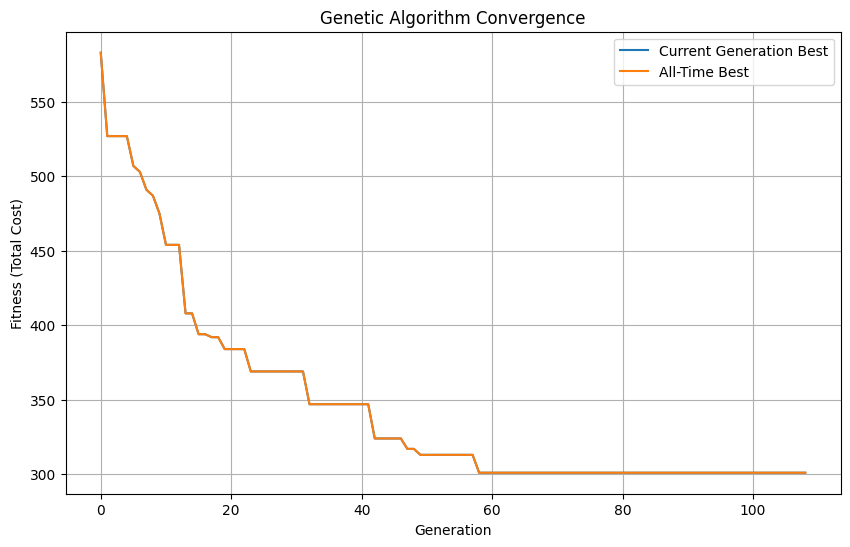

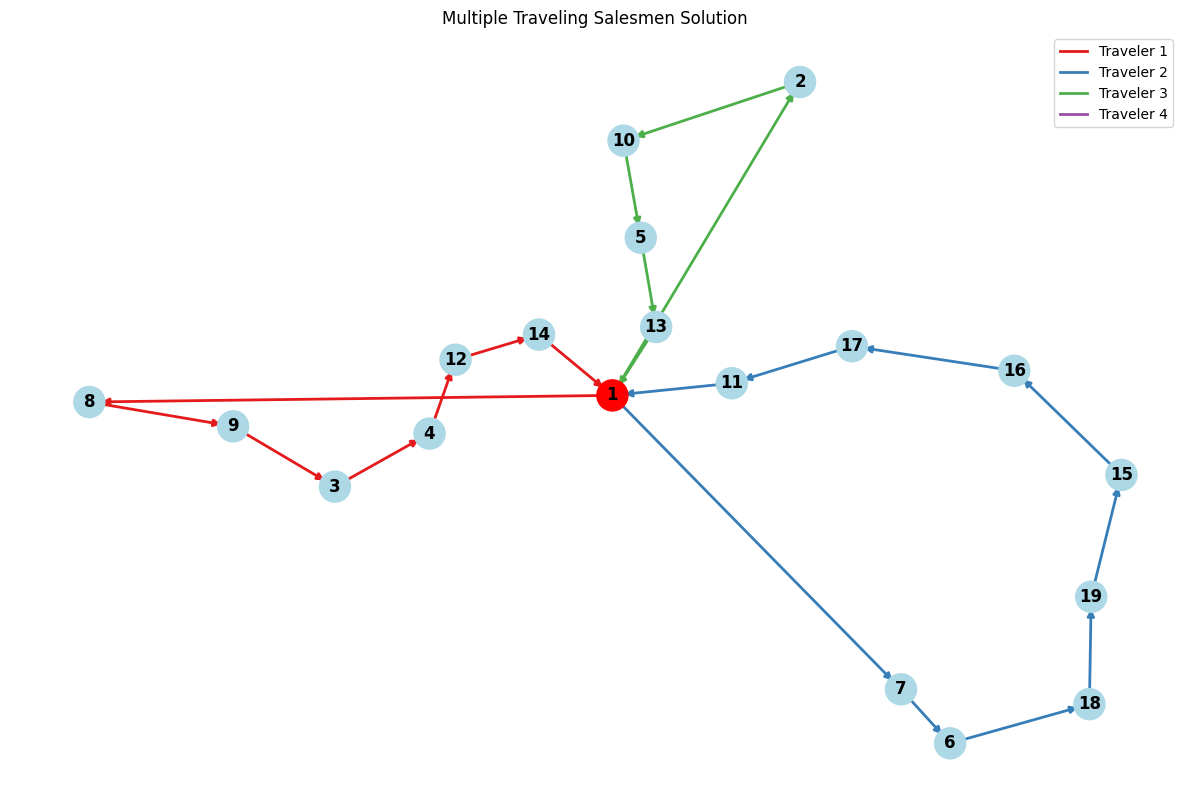

In [14]:
# Visualize Instance 3 results
ga_3.plot_convergence()
ga_3.plot_solution()

### Instance 4: Large Non-Metric Instance (100 nodes, 5 travelers)

In [15]:
# Instance 4: Large non-metric matrix with 100 nodes
print("=" * 80)
print("INSTANCE 4: Non-Metric n=100")
print("=" * 80)

# Load cost matrix
cost_matrix_4 = read_cost_matrix_csv('cost_matrix/make_non_metric_n100.csv')
num_cities_4 = len(cost_matrix_4)
num_travelers_4 = 5

print(f"Number of cities: {num_cities_4}")
print(f"Number of travelers: {num_travelers_4}")
print(f"Cost matrix shape: {cost_matrix_4.shape}\n")

# Create and run GA with larger parameters for large instance
ga_4 = GeneticAlgorithmMTSP(
    cost_matrix=cost_matrix_4,
    num_cities=num_cities_4,
    num_travelers=num_travelers_4,
    depots=[1],
    population_size=250,
    generations=500,
    mutation_rate=0.2,
    crossover_rate=0.8,
    elitism_rate=0.15,
    tournament_size=7
)

# Solve
best_solution_4, best_fitness_4 = ga_4.solve(verbose=True, early_stopping_generations=75)

# Display results
print("\n" + ga_4.get_solution_details())
print("\n" + "=" * 80 + "\n")

INSTANCE 4: Non-Metric n=100
Number of cities: 99
Number of travelers: 5
Cost matrix shape: (99, 100)

Generation 0: Best Fitness = 2348.00, Current Best = 2348.00, Time = 0.05s
Generation 10: Best Fitness = 1966.00, Current Best = 1966.00, Time = 0.49s
Generation 20: Best Fitness = 1790.00, Current Best = 1790.00, Time = 0.89s
Generation 30: Best Fitness = 1589.00, Current Best = 1589.00, Time = 1.34s
Generation 40: Best Fitness = 1475.00, Current Best = 1475.00, Time = 1.74s
Generation 50: Best Fitness = 1368.00, Current Best = 1368.00, Time = 2.15s
Generation 60: Best Fitness = 1316.00, Current Best = 1316.00, Time = 2.55s
Generation 70: Best Fitness = 1260.00, Current Best = 1260.00, Time = 2.95s
Generation 80: Best Fitness = 1185.00, Current Best = 1185.00, Time = 3.36s
Generation 90: Best Fitness = 1139.00, Current Best = 1139.00, Time = 3.76s
Generation 100: Best Fitness = 1109.00, Current Best = 1109.00, Time = 4.17s
Generation 110: Best Fitness = 1050.00, Current Best = 1050.0

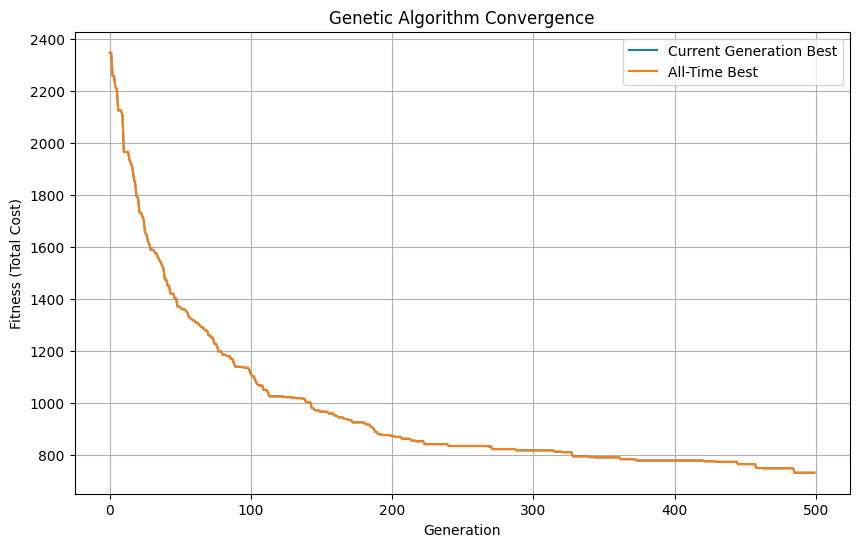

In [16]:
# Visualize Instance 4 results (convergence only - solution graph would be too crowded)
ga_4.plot_convergence()

### Instance 5: Comparison Across Different Configurations

This example demonstrates running the same instance with different GA parameters to compare performance.

In [17]:
# Instance 5: Parameter comparison on n=50 instance
print("=" * 80)
print("INSTANCE 5: Parameter Comparison on Asymmetric n=50")
print("=" * 80)

# Load cost matrix
cost_matrix_5 = read_cost_matrix_csv('cost_matrix/asymmetric_from_symmetric_n50.csv')
num_cities_5 = len(cost_matrix_5)
num_travelers_5 = 5

print(f"Number of cities: {num_cities_5}")
print(f"Number of travelers: {num_travelers_5}\n")

# Configuration 1: Low mutation rate
print("-" * 80)
print("Configuration 1: Low Mutation Rate (0.1)")
print("-" * 80)
ga_5a = GeneticAlgorithmMTSP(
    cost_matrix=cost_matrix_5,
    num_cities=num_cities_5,
    num_travelers=num_travelers_5,
    depots=[1],
    population_size=200,
    generations=300,
    mutation_rate=0.1,  # Low mutation
    crossover_rate=0.9,
    elitism_rate=0.1,
    tournament_size=5
)
best_solution_5a, best_fitness_5a = ga_5a.solve(verbose=False, early_stopping_generations=60)
print(f"Best fitness: {best_fitness_5a:.2f}\n")

# Configuration 2: High mutation rate
print("-" * 80)
print("Configuration 2: High Mutation Rate (0.3)")
print("-" * 80)
ga_5b = GeneticAlgorithmMTSP(
    cost_matrix=cost_matrix_5,
    num_cities=num_cities_5,
    num_travelers=num_travelers_5,
    depots=[1],
    population_size=200,
    generations=300,
    mutation_rate=0.3,  # High mutation
    crossover_rate=0.9,
    elitism_rate=0.1,
    tournament_size=5
)
best_solution_5b, best_fitness_5b = ga_5b.solve(verbose=False, early_stopping_generations=60)
print(f"Best fitness: {best_fitness_5b:.2f}\n")

# Configuration 3: Larger population
print("-" * 80)
print("Configuration 3: Larger Population (400)")
print("-" * 80)
ga_5c = GeneticAlgorithmMTSP(
    cost_matrix=cost_matrix_5,
    num_cities=num_cities_5,
    num_travelers=num_travelers_5,
    depots=[1],
    population_size=400,  # Larger population
    generations=200,
    mutation_rate=0.2,
    crossover_rate=0.9,
    elitism_rate=0.1,
    tournament_size=5
)
best_solution_5c, best_fitness_5c = ga_5c.solve(verbose=False, early_stopping_generations=60)
print(f"Best fitness: {best_fitness_5c:.2f}\n")

# Compare results
print("=" * 80)
print("COMPARISON SUMMARY")
print("=" * 80)
print(f"Configuration 1 (Low Mutation):     {best_fitness_5a:.2f}")
print(f"Configuration 2 (High Mutation):    {best_fitness_5b:.2f}")
print(f"Configuration 3 (Large Population): {best_fitness_5c:.2f}")
print("=" * 80)

INSTANCE 5: Parameter Comparison on Asymmetric n=50
Number of cities: 49
Number of travelers: 5

--------------------------------------------------------------------------------
Configuration 1: Low Mutation Rate (0.1)
--------------------------------------------------------------------------------
Best fitness: 742.00

--------------------------------------------------------------------------------
Configuration 2: High Mutation Rate (0.3)
--------------------------------------------------------------------------------
Best fitness: 629.00

--------------------------------------------------------------------------------
Configuration 3: Larger Population (400)
--------------------------------------------------------------------------------
Best fitness: 776.00

COMPARISON SUMMARY
Configuration 1 (Low Mutation):     742.00
Configuration 2 (High Mutation):    629.00
Configuration 3 (Large Population): 776.00
